In [672]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, fbeta_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb



RANDOM_STATE = 42
TEST_SIZE=0.1

In [804]:
def preprocess_data(df):
    """
    Функция для базовой предобработки данных
    
    Параметры:
    df (pandas.DataFrame): Входной датафрейм
    
    Возвращает:
    pandas.DataFrame: Предобработанный датафрейм
    """
    # Создаем копию датафрейма
    df_processed = df.copy()
    
    # 1. Заменим названия столбцов на snake_case
    for col in df_processed.columns:
        df_processed.rename(columns={col: col.strip().replace(' ',"_")}, inplace=True)
    
    # 2. Обработка пропущенных значений
    # Удаление строк, где все значения отсутствуют
    #df_processed.dropna(how='all', inplace=True)
    
    # 3. Приведение названий колонок к нижнему регистру
    df_processed.columns = df_processed.columns.str.lower()
    
    # 4. Изучаем количественные переменные
    numeric_columns = df_processed.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_columns:
        count_NA_num = df_processed[col].isna().sum()
        print(f"Количество пропусков в колонке {col}: {count_NA_num} \n")
        
    # 5. Изучаем категориальные значения
    categorical_columns = df_processed.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        count_NA_cat = df_processed[col].isna().sum()
        print(f"Количество пропусков в колонке {col}: {count_NA_cat}")
        print(f"Уникальные значения {col}: {df_processed[col].unique()} \n")
    
    # 6. Удаление дубликатов
    df_processed.drop_duplicates(inplace=True)
    
    
    # 7. Удаление пробелов в строковых значениях
    for col in categorical_columns:
        df_processed[col] = df_processed[col].str.strip()
    
    return df_processed

In [805]:
#load datasets
df = pd.read_csv('heart_train.csv', index_col=0)
df_test = pd.read_csv('heart_test.csv', index_col=0)

In [806]:
df = preprocess_data(df)


Количество пропусков в колонке age: 0 

Количество пропусков в колонке cholesterol: 0 

Количество пропусков в колонке heart_rate: 0 

Количество пропусков в колонке diabetes: 243 

Количество пропусков в колонке family_history: 243 

Количество пропусков в колонке smoking: 243 

Количество пропусков в колонке obesity: 243 

Количество пропусков в колонке alcohol_consumption: 243 

Количество пропусков в колонке exercise_hours_per_week: 0 

Количество пропусков в колонке diet: 0 

Количество пропусков в колонке previous_heart_problems: 243 

Количество пропусков в колонке medication_use: 243 

Количество пропусков в колонке stress_level: 243 

Количество пропусков в колонке sedentary_hours_per_day: 0 

Количество пропусков в колонке income: 0 

Количество пропусков в колонке bmi: 0 

Количество пропусков в колонке triglycerides: 0 

Количество пропусков в колонке physical_activity_days_per_week: 243 

Количество пропусков в колонке sleep_hours_per_day: 0 

Количество пропусков в колонк

In [807]:
for col in df.columns:
    if df[col].dtype == 'float64' and df[col].nunique() == 2:
        try:
            df[col] = df[col].astype('int64')
        except:
            pass
        
df['gender'] = df['gender'].astype('category')

In [808]:
df.drop(df[df['gender'] == '1.0'].index, inplace=True)
df.drop(df[df['gender'] == '0.0'].index, inplace=True)

<Axes: ylabel='Frequency'>

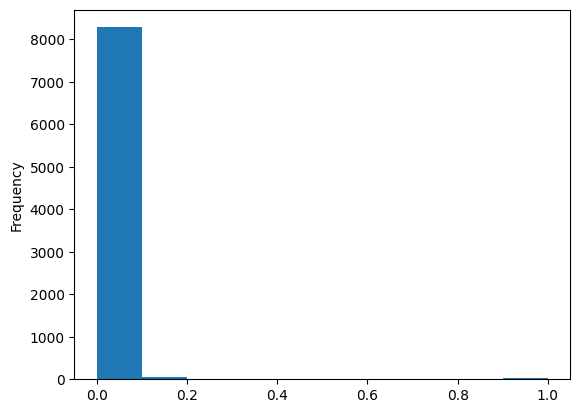

In [809]:
df['ck-mb'].plot(kind='hist')

In [810]:
df['phys']=MinMaxScaler().fit_transform(df[['physical_activity_days_per_week']])
#df['diet_min']=MinMaxScaler().fit_transform(df[['diet']])
#df['stress']=MinMaxScaler().fit_transform(df[['stress_level']])
df.drop(columns=['physical_activity_days_per_week'])

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id,phys
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,...,0.333333,0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664,0.428571
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,...,0.833333,0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287,0.428571
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,...,1.000000,0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379,0.285714
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,...,0.333333,1,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222,0.000000
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,...,1.000000,1,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047,0.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8680,0.359551,0.357143,0.040330,1.0,0.0,1.0,1.0,1.0,0.926662,2,...,0.166667,0,0.136364,0.006771,0.088261,Male,0.632258,0.511628,5734,0.000000
8681,0.516854,0.832143,0.036664,1.0,1.0,1.0,1.0,1.0,0.455572,2,...,0.833333,0,0.195652,0.008339,0.000777,Male,0.561290,0.511628,5191,0.857143
8682,0.471910,0.067857,0.023831,1.0,0.0,1.0,0.0,1.0,0.076336,2,...,0.833333,0,0.227018,0.048229,0.036512,Male,0.374194,0.558140,5390,0.142857
8683,0.595506,0.000000,0.075160,0.0,1.0,1.0,0.0,1.0,0.371759,2,...,0.500000,0,0.227018,0.048229,0.036512,Male,0.477419,0.744186,860,0.571429


In [811]:
# df = df.loc[df['troponin'] < 0.08]
# df = df.loc[df['ck-mb'] < 0.1]
# df = df.loc[df['blood_sugar'] < 0.4]


In [812]:
df=df[[
   'bmi','diastolic_blood_pressure','triglycerides','exercise_hours_per_week',
   'sedentary_hours_per_day', 'heart_attack_risk_(binary)','systolic_blood_pressure','age', 'phys', 'cholesterol', 'heart_rate']]

In [813]:
X_train, X_test, y_train, y_test = train_test_split(
      df.drop(columns=['heart_attack_risk_(binary)'], axis=1), #восстановить фэмили
      df['heart_attack_risk_(binary)'],
      test_size = TEST_SIZE, 
      random_state = RANDOM_STATE)

In [814]:

# Подсчёт веса для каждого класса
class_counts = np.bincount(y_train)
total = sum(class_counts)
class_weights = [total / c for c in class_counts]

# Пример: если классов два
print("Веса классов:", class_weights)

Веса классов: [np.float64(1.5497756017951856), np.float64(2.8189239332096476)]


In [815]:
#model = CatBoostClassifier(l2_leaf_reg=1, learning_rate=1, iterations=500, depth=16, border_count=32, cat_features=['gender'], class_weights=class_weights, loss_function='Logloss', eval_metric='Recall')
#model = CatBoostClassifier(l2_leaf_reg=2, learning_rate=0.1, iterations=1000, depth=1, early_stopping_rounds=50, cat_features=[], class_weights=class_weights, loss_function='Logloss', eval_metric='F1')
model = CatBoostClassifier(l2_leaf_reg=3, learning_rate=1, iterations=1000, depth=3, early_stopping_rounds=50, cat_features=[], class_weights=class_weights, loss_function='Logloss', eval_metric='Recall')
model.fit(X_train, y_train)

0:	learn: 0.7576994	total: 2.77ms	remaining: 2.77s
1:	learn: 0.4044527	total: 4.61ms	remaining: 2.3s
2:	learn: 0.5413729	total: 6.93ms	remaining: 2.3s
3:	learn: 0.5625232	total: 8.62ms	remaining: 2.15s
4:	learn: 0.5413729	total: 10.1ms	remaining: 2.01s
5:	learn: 0.5499072	total: 11.7ms	remaining: 1.94s
6:	learn: 0.5521336	total: 13.4ms	remaining: 1.9s
7:	learn: 0.5547310	total: 15.1ms	remaining: 1.87s
8:	learn: 0.5673469	total: 16.5ms	remaining: 1.82s
9:	learn: 0.5658627	total: 18.1ms	remaining: 1.79s
10:	learn: 0.5892393	total: 20.1ms	remaining: 1.81s
11:	learn: 0.5777365	total: 22ms	remaining: 1.81s
12:	learn: 0.5821892	total: 23.7ms	remaining: 1.8s
13:	learn: 0.5766234	total: 25.3ms	remaining: 1.78s
14:	learn: 0.5732839	total: 26.8ms	remaining: 1.76s
15:	learn: 0.5755102	total: 27.9ms	remaining: 1.72s
16:	learn: 0.5784787	total: 29.3ms	remaining: 1.69s
17:	learn: 0.5888683	total: 30.6ms	remaining: 1.67s
18:	learn: 0.5825603	total: 32ms	remaining: 1.65s
19:	learn: 0.5862709	total: 33

In [816]:
threshold = 0.4

y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype(int)

recall_score(y_test, y_pred), fbeta_score(y_test, y_pred, beta=1), roc_auc_score(y_test, y_pred)


(0.4779874213836478, 0.44903988183161003, np.float64(0.542599023784803))

In [817]:
features = model.get_feature_importance(prettified=True)
features

,Feature Id,Importances
0,sedentary_hours_per_day,13.137176
1,bmi,12.714584
2,exercise_hours_per_week,12.050104
3,cholesterol,11.841037
4,triglycerides,11.646191
5,age,9.618013
6,systolic_blood_pressure,8.860493
7,heart_rate,8.523191
8,diastolic_blood_pressure,8.424470
9,phys,3.184741


In [818]:

model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=12,
    scale_pos_weight=3,  # если дисбаланс
    eval_metric='auc',
    use_label_encoder=False,
    early_stopping_rounds=50,
    enable_categorical=True
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)]
)

[0]	validation_0-auc:0.51303


[1]	validation_0-auc:0.50750
[2]	validation_0-auc:0.51795
[3]	validation_0-auc:0.52502
[4]	validation_0-auc:0.53006
[5]	validation_0-auc:0.53837
[6]	validation_0-auc:0.53715
[7]	validation_0-auc:0.53305
[8]	validation_0-auc:0.53793
[9]	validation_0-auc:0.54021
[10]	validation_0-auc:0.54172
[11]	validation_0-auc:0.54605
[12]	validation_0-auc:0.54638
[13]	validation_0-auc:0.54519
[14]	validation_0-auc:0.55065
[15]	validation_0-auc:0.55054
[16]	validation_0-auc:0.55201
[17]	validation_0-auc:0.55296
[18]	validation_0-auc:0.55098
[19]	validation_0-auc:0.55325
[20]	validation_0-auc:0.55205
[21]	validation_0-auc:0.54866
[22]	validation_0-auc:0.54858
[23]	validation_0-auc:0.55243
[24]	validation_0-auc:0.55131


/Users/mikhailpuchkov/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [21:36:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-auc:0.55190
[26]	validation_0-auc:0.55523
[27]	validation_0-auc:0.55842
[28]	validation_0-auc:0.55821
[29]	validation_0-auc:0.55912
[30]	validation_0-auc:0.56104
[31]	validation_0-auc:0.56200
[32]	validation_0-auc:0.56311
[33]	validation_0-auc:0.56461
[34]	validation_0-auc:0.56337
[35]	validation_0-auc:0.56693
[36]	validation_0-auc:0.56452
[37]	validation_0-auc:0.56674
[38]	validation_0-auc:0.56852
[39]	validation_0-auc:0.56956
[40]	validation_0-auc:0.57126
[41]	validation_0-auc:0.57065
[42]	validation_0-auc:0.56570
[43]	validation_0-auc:0.56547
[44]	validation_0-auc:0.56484
[45]	validation_0-auc:0.56614
[46]	validation_0-auc:0.56757
[47]	validation_0-auc:0.56661
[48]	validation_0-auc:0.56605
[49]	validation_0-auc:0.56665
[50]	validation_0-auc:0.56720
[51]	validation_0-auc:0.56966
[52]	validation_0-auc:0.56829
[53]	validation_0-auc:0.56686
[54]	validation_0-auc:0.56709
[55]	validation_0-auc:0.56949
[56]	validation_0-auc:0.56887
[57]	validation_0-auc:0.57107
[58]	valid

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [819]:
threshold = 0.1

y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype(int)

recall_score(y_test, y_pred), fbeta_score(y_test, y_pred, beta=1), roc_auc_score(y_test, y_pred)


(0.9716981132075472, 0.5464190981432361, np.float64(0.5076706884823314))

(array([12.,  5., 12.,  8., 24., 29., 19., 17., 25., 23., 22., 26., 27.,
        30., 31., 21., 37., 37., 12., 33., 20., 22., 25., 19., 18., 17.,
        21., 30., 19., 23., 18., 11.,  8., 11., 23., 16., 15., 11.,  7.,
         7., 12.,  4.,  3.,  4.,  3.,  5.,  6.,  6.,  6.,  5.]),
 array([0.03438457, 0.05347106, 0.07255755, 0.09164403, 0.11073051,
        0.12981701, 0.14890349, 0.16798998, 0.18707646, 0.20616294,
        0.22524944, 0.24433592, 0.2634224 , 0.28250888, 0.30159539,
        0.32068187, 0.33976835, 0.35885483, 0.37794131, 0.39702782,
        0.4161143 , 0.43520078, 0.45428726, 0.47337374, 0.49246022,
        0.51154673, 0.53063321, 0.54971969, 0.56880617, 0.58789265,
        0.60697913, 0.62606561, 0.64515209, 0.66423857, 0.68332505,
        0.70241153, 0.72149801, 0.74058449, 0.75967103, 0.77875751,
        0.79784399, 0.81693047, 0.83601695, 0.85510343, 0.87418991,
        0.89327639, 0.91236287, 0.93144935, 0.95053583, 0.96962237,
        0.98870879]),
 <BarContainer

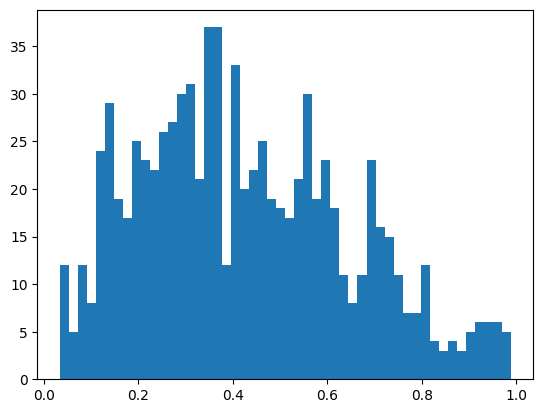

In [820]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
import matplotlib.pyplot as plt
plt.hist(y_pred_proba, bins=50)

In [821]:
from sklearn.metrics import make_scorer, fbeta_score

n_estimators=1000,

pipe_final = Pipeline([
    ('models', 'passthrough')
])
    
param_grid = [
    {
        'models': [xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='auc', use_label_encoder=False, enable_categorical=True)],
        'models__n_estimators': [100, 1000, 2000],
        'models__max_depth': [4, 8, 10, 12, 16],
        'models__learning_rate': [0.1, 1],
        'models__scale_pos_weight': [1, 3, None],
        'models__subsample': [0.6, 0.8, 1.0],
        'models__colsample_bytree': [0.6, 0.8, 1.0],
        'models__scale_pos_weight': [1, 3, 5, 10],
        'models__min_child_weight': [1, 5, 10],
        'models__gamma': [0, 1, 5],
        'models__reg_alpha': [0, 0.1, 1],
        'models__reg_lambda': [1, 5, 10],
    },

]

f1_scorer = make_scorer(fbeta_score, beta=1, average='macro')

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    n_iter=50,
    cv=5,
    scoring={'roc_auc': 'roc_auc', 'f1': f1_scorer},
    refit='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

/Users/mikhailpuchkov/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [21:36:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mikhailpuchkov/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [21:36:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mikhailpuchkov/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [21:36:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mikhailpuchkov/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [21:36:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } ar

RandomizedSearchCV(cv=5, estimator=Pipeline(steps=[('models', 'passthrough')]),
                   n_iter=50, n_jobs=-1,
                   param_distributions=[{'models': [XGBClassifier(base_score=None,
                                                                  booster=None,
                                                                  callbacks=None,
                                                                  colsample_bylevel=None,
                                                                  colsample_bynode=None,
                                                                  colsample_bytree=None,
                                                                  device=None,
                                                                  early_stopping_rounds=None,
                                                                  enable_categorical=True,
                                                                  eval_metric='auc',
                                                                  feature_types=N...
                                         'models__max_depth': [4, 8, 10, 12,
                                                               16],
                                         'models__min_child_weight': [1, 5, 10],
                                         'models__n_estimators': [100, 1000,
                                                                  2000],
                                         'models__reg_alpha': [0, 0.1, 1],
                                         'models__reg_lambda': [1, 5, 10],
                                         'models__scale_pos_weight': [1, 3, 5,
                                                                      10],
                                         'models__subsample': [0.6, 0.8, 1.0]}],
                   random_state=42, refit='f1',
                   scoring={'f1': make_scorer(fbeta_score, response_method='predict', beta=1, average=macro),
                            'roc_auc': 'roc_auc'})

In [822]:
print('Лучшая модель и её параметры:\n', randomized_search.best_estimator_ , randomized_search.best_estimator_.get_params())
print('score на кросс-вадидационной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:
 Pipeline(steps=[('models',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric='auc',
                               feature_types=None, gamma=0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=16, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                          

In [ ]:
best_model = randomized_search.best_estimator_.named_steps['models']
best_params = best_model.get_params()
model = xgb.XGBClassifier(**best_params)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)]
)

[0]	validation_0-auc:0.52647
[1]	validation_0-auc:0.55096
[2]	validation_0-auc:0.56173
[3]	validation_0-auc:0.54932
[4]	validation_0-auc:0.55417
[5]	validation_0-auc:0.55169
[6]	validation_0-auc:0.56095
[7]	validation_0-auc:0.54888
[8]	validation_0-auc:0.54835
[9]	validation_0-auc:0.54919
[10]	validation_0-auc:0.56008
[11]	validation_0-auc:0.55094
[12]	validation_0-auc:0.55386
[13]	validation_0-auc:0.55230
[14]	validation_0-auc:0.55360
[15]	validation_0-auc:0.54835
[16]	validation_0-auc:0.54697
[17]	validation_0-auc:0.54475
[18]	validation_0-auc:0.54388
[19]	validation_0-auc:0.54105
[20]	validation_0-auc:0.53952
[21]	validation_0-auc:0.53395
[22]	validation_0-auc:0.54015
[23]	validation_0-auc:0.54028
[24]	validation_0-auc:0.54192
[25]	validation_0-auc:0.53875
[26]	validation_0-auc:0.54251
[27]	validation_0-auc:0.54688
[28]	validation_0-auc:0.54181
[29]	validation_0-auc:0.54203
[30]	validation_0-auc:0.54503
[31]	validation_0-auc:0.55090
[32]	validation_0-auc:0.54668


/Users/mikhailpuchkov/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [21:37:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[33]	validation_0-auc:0.55173
[34]	validation_0-auc:0.55270
[35]	validation_0-auc:0.55653
[36]	validation_0-auc:0.55678
[37]	validation_0-auc:0.55340
[38]	validation_0-auc:0.55179
[39]	validation_0-auc:0.54920
[40]	validation_0-auc:0.54856
[41]	validation_0-auc:0.54463
[42]	validation_0-auc:0.54998
[43]	validation_0-auc:0.55250
[44]	validation_0-auc:0.54975
[45]	validation_0-auc:0.54984
[46]	validation_0-auc:0.55042
[47]	validation_0-auc:0.54859
[48]	validation_0-auc:0.54871
[49]	validation_0-auc:0.54883
[50]	validation_0-auc:0.54419
[51]	validation_0-auc:0.54703
[52]	validation_0-auc:0.54326
[53]	validation_0-auc:0.54247
[54]	validation_0-auc:0.54894
[55]	validation_0-auc:0.55218
[56]	validation_0-auc:0.55284
[57]	validation_0-auc:0.55005
[58]	validation_0-auc:0.55579
[59]	validation_0-auc:0.55769
[60]	validation_0-auc:0.55699
[61]	validation_0-auc:0.55668
[62]	validation_0-auc:0.55154
[63]	validation_0-auc:0.55195
[64]	validation_0-auc:0.55089
[65]	validation_0-auc:0.55315
[66]	valid

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [824]:
threshold = 0.5

y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype(int)

recall_score(y_test, y_pred), fbeta_score(y_test, y_pred, beta=1), roc_auc_score(y_test, y_pred)


(0.3584905660377358, 0.38578680203045684, np.float64(0.5283913930757939))

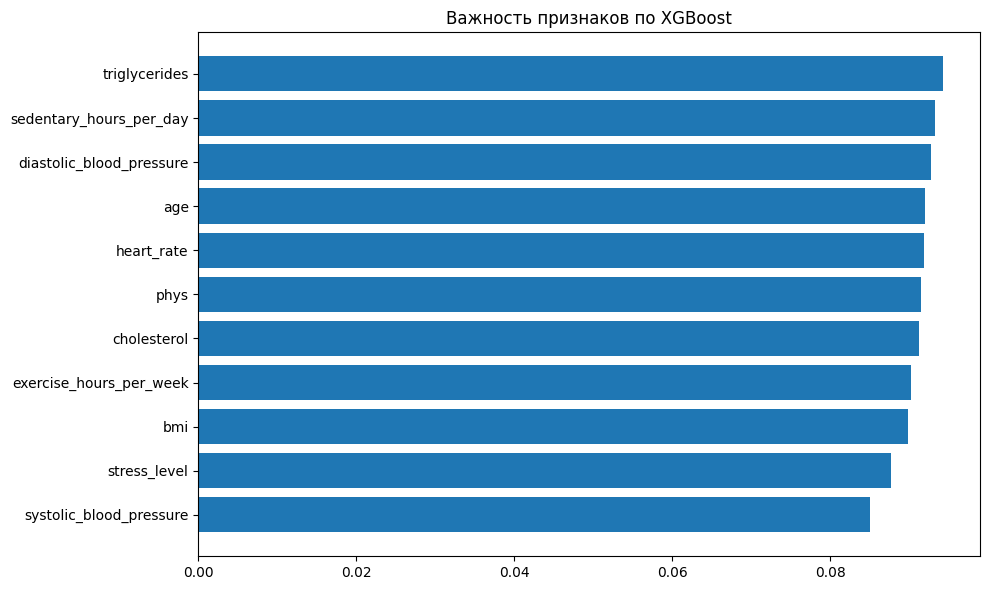

In [802]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Важность признаков
importances = model.feature_importances_
feature_names = X_train.columns

# В Pandas DataFrame для удобства
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()
plt.title('Важность признаков по XGBoost')
plt.tight_layout()
plt.show()

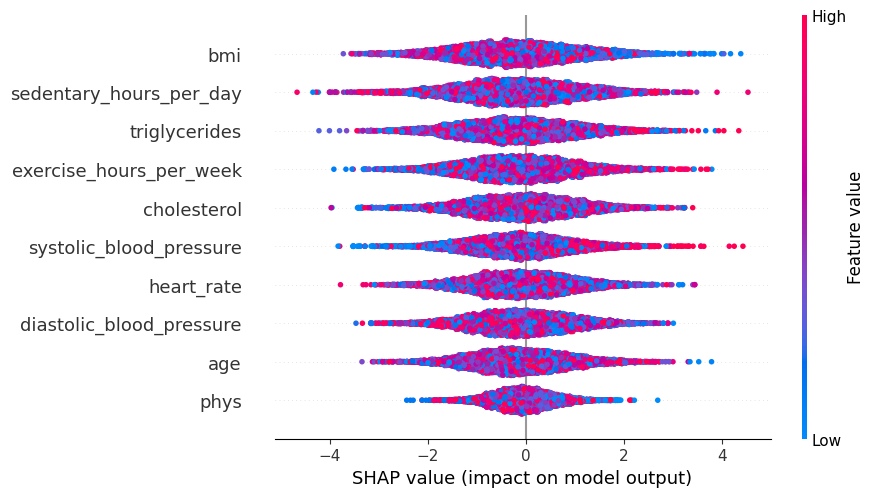

In [825]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# Визуализация
shap.plots.beeswarm(shap_values, max_display=20)

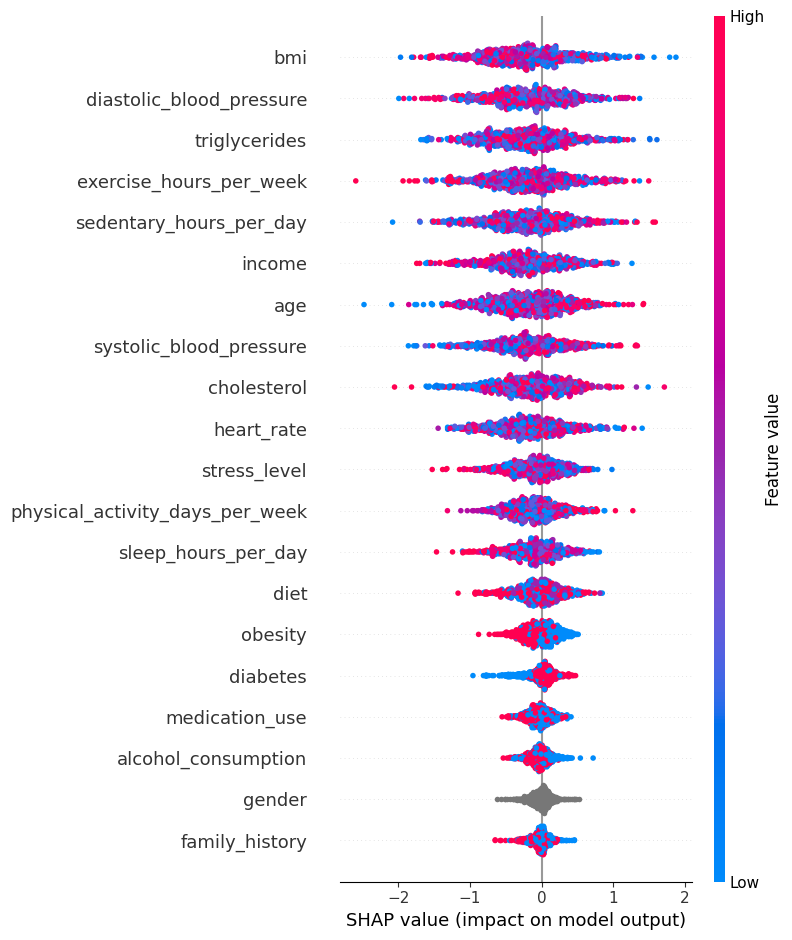

In [528]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

In [536]:
shap_df = pd.DataFrame(np.abs(shap_values.values), columns=X_test.columns)
mean_abs_shap = shap_df.mean().sort_values(ascending=False)

# Топ-5 признаков и их вклад
top_5_features = mean_abs_shap.head(5).to_dict()

print(top_5_features)

{'bmi': 0.49790698289871216, 'diastolic_blood_pressure': 0.4436735510826111, 'triglycerides': 0.4409400224685669, 'exercise_hours_per_week': 0.4389439523220062, 'sedentary_hours_per_day': 0.43124571442604065}


In [581]:
shap_df

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,gender,systolic_blood_pressure,diastolic_blood_pressure,phys
0,0.653223,0.527074,0.292663,0.196926,0.038886,0.002987,0.243423,0.067573,0.519089,0.347350,...,0.359322,0.709309,0.198348,0.101408,0.092524,0.026444,0.024588,0.123602,1.205047,0.0
1,0.054586,0.786212,0.261619,0.450265,0.023023,0.037807,0.134169,0.109644,0.283036,0.468664,...,0.391739,0.730897,0.275302,0.266336,0.300647,0.009090,0.093508,0.316175,0.149907,0.0
2,0.644207,0.145788,0.176425,0.049443,0.078033,0.005287,0.069683,0.075337,0.817867,0.435542,...,0.876086,0.587432,0.167146,0.274783,0.783772,0.063523,0.029432,0.771516,0.577828,0.0
3,0.432017,0.005999,0.698094,0.105467,0.123049,0.081034,0.019662,0.121875,0.048850,0.232995,...,0.396339,0.514596,0.503636,0.056162,0.010404,0.033340,0.008304,0.246288,0.181234,0.0
4,0.049306,0.955981,0.078980,0.186130,0.097375,0.003615,0.218317,0.076975,0.520506,0.023453,...,0.591476,0.057841,0.157007,0.096770,0.124609,0.034117,0.033091,0.072512,0.192927,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,0.231022,0.217627,0.061151,0.033348,0.079787,0.012358,0.100422,0.013316,0.293524,0.478347,...,0.365144,1.045385,0.130981,0.039277,0.069273,0.008411,0.127240,0.115926,0.074186,0.0
785,0.143859,0.222114,0.145115,0.020713,0.004370,0.025891,0.234173,0.012065,0.467484,0.006336,...,0.466050,0.588419,0.421519,0.172015,0.204053,0.041505,0.088704,0.860663,0.385577,0.0
786,0.277517,0.195587,0.164906,0.173842,0.228972,0.002987,0.257950,0.258677,0.655585,0.279032,...,1.160492,0.327361,0.215212,0.403971,0.013671,0.020759,0.164752,0.533551,0.776345,0.0
787,0.708234,1.098721,0.831470,0.334843,0.012610,0.033311,0.047810,0.002956,0.529150,0.037553,...,0.173595,0.893927,0.495464,0.260583,0.046070,0.032613,0.078749,0.114204,0.966661,0.0
